In [ ]:
# 安装第三方库
!pip install torcheval

In [2]:
import torch
import torch.nn.functional as F
from utils import Linear
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline

# 固定随机数生成种子，使得计算结果可以复现
torch.manual_seed(1024)

In [3]:
def read_data(path):
    """
    使用pandas读取数据
    """
    data = pd.read_csv(path)
    cols = ["age", "education_num", "capital_gain", "capital_loss", "hours_per_week", "label"]
    return data[cols]


if os.name == "nt":
    data_path = ".\\data\\adult.data"
else:
    data_path = "./data/adult.data"
data = read_data(data_path)
data["label_code"] = pd.Categorical(data.label).codes

In [4]:
# 展示数据
data

,age,education_num,capital_gain,capital_loss,hours_per_week,label,label_code
0,39,13,2174,0,40,<=50K,0
1,50,13,0,0,13,<=50K,0
2,38,9,0,0,40,<=50K,0
3,53,7,0,0,40,<=50K,0
4,28,13,0,0,40,<=50K,0
...,...,...,...,...,...,...,...
32556,27,12,0,0,38,<=50K,0
32557,40,9,0,0,40,>50K,1
32558,58,9,0,0,40,<=50K,0
32559,22,9,0,0,20,<=50K,0


In [5]:
class LogitRegression:
    
    def __init__(self, neg, pos):
        '''
        定义逻辑回归模型的结构
        参数
        ----
        neg ：Linear，负面的偏好，模型的形状为(k, 1)
        pos ：Linear，正面的偏好，模型的形状为(k, 1)
        '''
        self.pos = pos
        self.neg = neg
        
    def __call__(self, x):
        '''
        逻辑回归模型的向前传播
        参数
        ----
        x ：torch.FloatTensor，形状为(n, k)
        '''
        self.out = torch.concat((self.neg(x), self.pos(x)), dim=1)
        return self.out  # (n, 2)
    
    def parameters(self):
        return self.neg.parameters() + self.pos.parameters()

In [6]:
# 定义模型
pos = Linear(5, 1)
neg = Linear(5, 1)
model = LogitRegression(neg, pos)

In [7]:
# 准备数据
x = torch.tensor(data[['age', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']].values).float()
x = F.normalize(x)                           # (32561, 5)
y = torch.tensor(data['label_code']).long()  # (32561)

In [8]:
# 使用模型
## 注意，模型输入数据的形状一定要是(n, 5)
logits = model(x[[1]])            # (1, 2)
probs = F.softmax(logits, dim=1)  # (1, 2)
pred = torch.where(probs[:, 1] > 0.5, 1, 0)
logits, probs, pred

(tensor([[ 1.2665, -1.7305]]), tensor([[0.9524, 0.0476]]), tensor([0]))

In [9]:
# 计算模型在单点的损失
loss = F.cross_entropy(logits, y[[1]])
# cross_entropy的具体实现过程
-probs[torch.arange(1), y[[1]]].log().mean(), loss

(tensor(0.0487), tensor(0.0487))

In [10]:
# 对于模型参数，需要记录它们的梯度（为反向传播做准备）
for p in model.parameters():
    p.requires_grad = True

In [11]:
# 标准随机梯度下降法的超参数
max_steps = 20000
batch_size = 3000
lossi = []

for i in range(max_steps):
    # 构造批次训练数据
    ix = torch.randint(0, x.shape[0], (batch_size,))
    xb = x[ix]
    yb = y[ix]
    # 向前传播
    logits = model(xb)
    loss = F.cross_entropy(logits, yb)
    # 反向传播
    loss.backward()
    # 更新模型参数
    ## 学习速率衰减
    learning_rate = 0.1 if i < 10000 else 0.01
    with torch.no_grad():
        for p in model.parameters():
            p -= learning_rate * p.grad
            p.grad = None
        
    # 统计数据
    if i % 2000 == 0:
        print(f'step {i: 6d}/{max_steps}, loss: {loss.item(): .4f}')
    lossi.append(loss.item())

step      0/20000, loss:  0.6580
step   2000/20000, loss:  0.5092
step   4000/20000, loss:  0.5066
step   6000/20000, loss:  0.5037
step   8000/20000, loss:  0.4958
step  10000/20000, loss:  0.5046
step  12000/20000, loss:  0.5015
step  14000/20000, loss:  0.4952
step  16000/20000, loss:  0.5086
step  18000/20000, loss:  0.5086


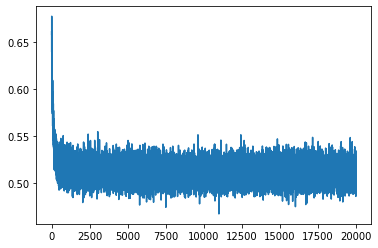

In [12]:
# 展示模型损失优化的过程
plt.plot(torch.tensor(lossi))

In [13]:
# 关闭梯度追踪
with torch.no_grad():
    logits = model(x)  
    probs = F.softmax(logits, dim=1)
    pred = torch.where(probs[:, 1] > 0.5, 1, 0)
logits.shape, probs.shape, pred.shape

(torch.Size([32561, 2]), torch.Size([32561, 2]), torch.Size([32561]))

In [14]:
from torcheval.metrics.functional.classification import binary_recall
from torcheval.metrics.functional import binary_precision, binary_f1_score
binary_recall(pred, y), binary_precision(pred, y), binary_f1_score(pred, y)

(tensor(0.2928), tensor(0.5902), tensor(0.3914))

In [15]:
# 展示如何利用排序数据得到对偏好的估计
# 此处只做模型结构展示，并不训练和使用模型
class PreferenceModel:
    
    def __init__(self, pref):
        self.pref = pref
        
    def __call__(self, x0, x1):
        self.out = torch.concat((self.pref(x0), self.pref(x1)), dim=1)
        return self.out
    
    def parameters(self):
        return self.pref.parameters()

In [16]:
# 预测偏好的模型
preference = Linear(5, 1)
# 将两个数据的偏好组合在一起，以便和排序数据结合在一起
p_model = PreferenceModel(preference)

In [17]:
# 随机选取x0和x1
x0 = x[[0]]
x1 = x[[1]]
p_logits = p_model(x0, x1)
# 得到有偏好推导出来的排序概率，该数据可以与观测到的实际排序相结合，定义模型损失
p_probs = F.softmax(p_logits, dim=1)
p_logits, p_probs

(tensor([[0.0679, 1.1044]]), tensor([[0.2618, 0.7382]]))